In [12]:
import os
import sys
import json
import torch
import numpy as np
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

sys.path.append('../../')
# sys.path.append('../../')

In [2]:
import matplotlib.pyplot as plt

%matplotlib inline

In [3]:
from utils import custom_transforms
from unet.torch_AMCDataset import AMCDataset
from unet.model_unet import UNet

In [4]:
def parse_input_arguments(out_dir):
    run_params = json.load(open(os.path.join(out_dir, "run_parameters.json"), "r"))
    return run_params


In [6]:
meta_path = "/export/scratch3/bvdp/segmentation/OAR_segmentation/data_preparation/meta/dataset_train_2019-12-17.csv"
root_dir = '/export/scratch3/bvdp/segmentation/data/MODIR_data_train_2019-12-17/'
label_mapping_path = '/export/scratch3/bvdp/segmentation/OAR_segmentation/data_preparation/meta/label_mapping_train_2019-12-17.json'

experiment_dir = '/export/scratch3/bvdp/segmentation/OAR_segmentation/experiments/unet/runs/downsample_171_img_depth_48_unet_width_64/cross_entropy/'
run_params = parse_input_arguments(experiment_dir)
image_size = run_params['image_size']
image_depth = run_params['image_depth']
filter_label = run_params['filter_label']

crop_inplane = 128
transform_train = custom_transforms.Compose([
    custom_transforms.CropDepthwise(crop_size=image_depth, crop_mode='random'),
    custom_transforms.CustomResize(output_size=image_size),
    custom_transforms.CropInplane(crop_size=crop_inplane, crop_mode='center'),
    custom_transforms.RandomBrightness(),
    custom_transforms.RandomContrast(),
    custom_transforms.RandomRotate3D(p=0.3)      
])

transform_val = custom_transforms.Compose([
    custom_transforms.CropDepthwise(crop_size=image_depth, crop_mode='random'),
    custom_transforms.CustomResize(output_size=image_size),
    custom_transforms.CropInplane(crop_size=crop_inplane, crop_mode='center')
])

train_dataset = AMCDataset(root_dir, meta_path, label_mapping_path, output_size=image_size, is_training=True, transform=transform_train, filter_label=filter_label, log_path=None)
val_dataset = AMCDataset(root_dir, meta_path, label_mapping_path, output_size=image_size, is_training=False, transform=transform_val, filter_label=filter_label, log_path=None)
train_dataloader = DataLoader(train_dataset, shuffle=False, batch_size=1)
val_dataloader = DataLoader(val_dataset, shuffle=False, batch_size=1)

In [7]:
device = 'cuda:2'

width, depth = run_params['width'], run_params['depth']

model = UNet(depth=depth, width=width, in_channels=1, out_channels=len(val_dataset.classes))
model.to(device)
print("model initialized")

# load weights
out_dir_wts = os.path.join(experiment_dir, 'weights')
state_dict = torch.load(os.path.join(out_dir_wts, "best_model.pth"), map_location=device)["model"]
model.load_state_dict(state_dict)
print("weights loaded")

model initialized
weights loaded


In [25]:
img, target = next(iter(val_dataloader))
img = img.to(device)

In [16]:
img.shape, target.shape

(torch.Size([1, 1, 48, 128, 128]), torch.Size([1, 48, 128, 128]))

In [32]:
# softmax(output).sum(dim=1)
softmax = nn.Softmax(dim=1)

with torch.no_grad():
    output = model(img)
    output_prob = softmax(output)
output_segmentation = torch.argmax(output, dim=1)#.view(*img.shape)

In [35]:
output.shape, output_segmentation.shape

(torch.Size([1, 5, 48, 128, 128]), torch.Size([1, 48, 128, 128]))

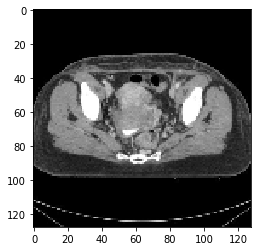

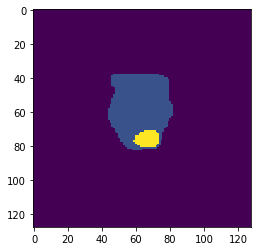

In [36]:
i_slice = 0

plt.imshow(img[0,0,i_slice].cpu().numpy(), cmap='gray')
plt.figure()
plt.imshow(target[0,i_slice].cpu().numpy())

In [39]:
np.unique(target[0,0].numpy().ravel()), np.unique(output_segmentation[0,0].cpu().numpy().ravel())

(array([0, 1, 4]), array([0, 1, 4]))

In [61]:
train_dataset.classes

['background', 'bowel_bag', 'bladder', 'hip', 'rectum']

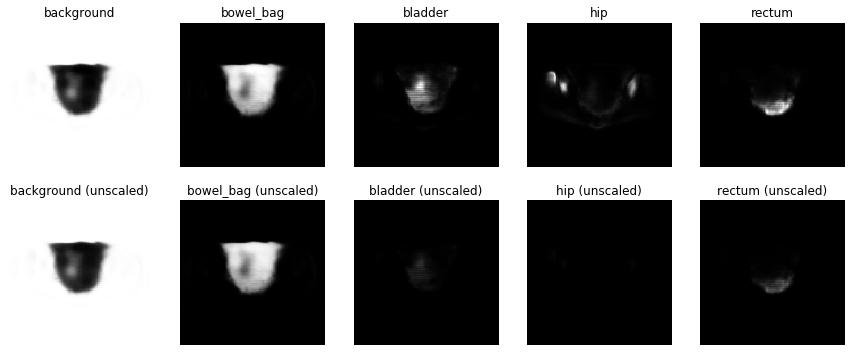

In [40]:
# output_np =  output.data.cpu().numpy()
vmin, vmax = output_prob.min().item(), output_prob.max().item()
fig, axes = plt.subplots(2,5, figsize=(15,6))
for i in range(5):
    ax_scaled = axes[0].ravel()[i]
    ax_unscaled = axes[1].ravel()[i]
    ax_scaled.imshow(output_prob[0,i,i_slice].data.cpu().numpy(), cmap='gray')
    ax_unscaled.imshow(output_prob[0,i,i_slice].data.cpu().numpy(), cmap='gray', vmin=0, vmax=1)
    ax_scaled.axis('off')
    ax_unscaled.axis('off')
    ax_scaled.set_title(train_dataset.classes[i])
    ax_unscaled.set_title(train_dataset.classes[i] + " (unscaled)")

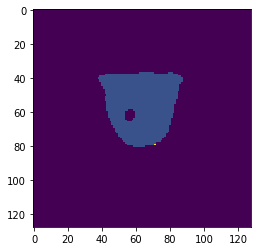

In [41]:
plt.imshow(output_segmentation[0][i_slice].cpu().numpy())

(array([15992.,    36.,    25.,    18.,    25.,    17.,    24.,    28.,
           47.,   172.]),
 array([1.7830569e-11, 9.9561475e-02, 1.9912295e-01, 2.9868442e-01,
        3.9824590e-01, 4.9780738e-01, 5.9736884e-01, 6.9693035e-01,
        7.9649180e-01, 8.9605331e-01, 9.9561477e-01], dtype=float32),
 <a list of 10 Patch objects>)

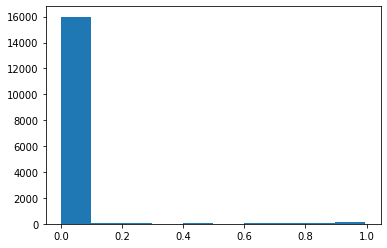

In [131]:
plt.hist(output_prob[0,4,i_slice].cpu().numpy().ravel())

In [206]:
# segmentation_np.sum()

In [204]:
class_segmentation.sum()

3073

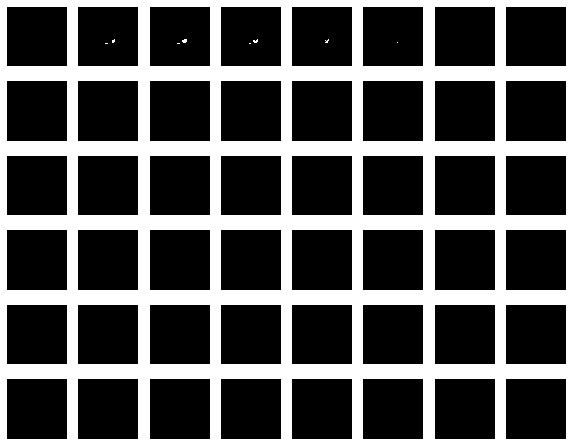

In [128]:
class_idx = 4

segmentation_np = output_segmentation.cpu().numpy()

fig, axes = plt.subplots(6, 8, figsize=(10,8))
for i in range(48):
    ax = axes.ravel()[i]
    class_segmentation = (segmentation_np == class_idx)
    ax.imshow(class_segmentation[0,i], cmap='gray', vmin=0, vmax=1)
    ax.axis('off')

In [121]:
class_segmentation.shape

(1, 48, 128, 128)

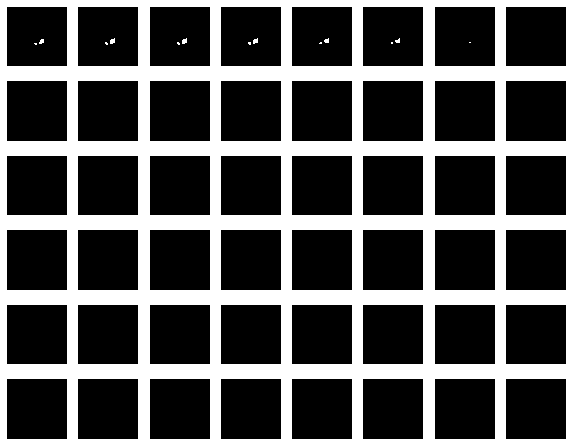

In [151]:
class_idx = 4

segmentation_np = output_segmentation.cpu().numpy()

struct = ndimage.generate_binary_structure(3, 3)

fig, axes = plt.subplots(6, 8, figsize=(10,8))
for i in range(48):
    ax = axes.ravel()[i]
    class_segmentation = (segmentation_np == class_idx)
    class_segmentation = ndimage.binary_dilation(class_segmentation[0], structure=struct)
    class_segmentation = np.expand_dims(class_segmentation, 0)
    ax.imshow(class_segmentation[0,i], cmap='gray', vmin=0, vmax=1)
    ax.axis('off')

In [102]:
from skimage.measure import label, regionprops

def postprocess_segmentation(segm_np, n_classes=5, bg_idx=0):
    segm_pp = segm_np.copy()
    for class_idx in range(n_classes):
        print(class_idx)
        if class_idx == bg_idx:
            continue

        initial_segmentation = segm_np == class_idx
        valid_mask, num = label(initial_segmentation, connectivity=2, return_num=True)
        props = regionprops(valid_mask)
        props = sorted(props, key=lambda x: x.area, reverse=True)

        if len(props) == 0:
            pass
        elif len(props) == 1 or props[0].area > 1.5*props[1].area:
            segm_pp[initial_segmentation & (valid_mask != props[0].label)] = bg_idx
            segm_pp[valid_mask == props[0].label] = class_idx
        else:
            mask = np.logical_or((valid_mask == props[0].label), (valid_mask == props[1].label))
            segm_pp[initial_segmentation & np.logical_not(mask)] = bg_idx
            segm_pp[mask] = class_idx
    return segm_pp

In [86]:
np.unique(segmentation_np[0])

array([0, 1, 4])

In [109]:
postprocessed = postprocess_segmentation(segmentation_np[0])
postprocessed = np.expand_dims(postprocessed, 0)
# postprocessed

0
Skipping 0
1
initial_segmentation sum:  58066
Num props 1
2
initial_segmentation sum:  0
Num props 0
Skipping 2
3
initial_segmentation sum:  0
Num props 0
Skipping 3
4
initial_segmentation sum:  235
Num props 2


In [104]:
np.unique(postprocessed)

array([0, 1, 4])

In [105]:
(postprocessed == 1).sum()

58066

In [398]:
np.unique(postprocessed)

array([0, 4])

In [391]:
# postprocessed

In [110]:
postprocessed.shape

(1, 48, 128, 128)

In [382]:
(segmentation_np & segmentation_np == 1).shape

(1, 48, 128, 128)

In [315]:
segmentation_np.max()

4

In [316]:
np.where(segmentation_np == 4)

(array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 array([41, 41, 41, 41, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 43, 43,
        43, 43, 43, 43, 44]),
 array([62, 63, 63, 63, 62, 62, 63, 63, 63, 63, 64, 64, 64, 65, 65, 63, 63,
        64, 64, 65, 65, 65]),
 array([90, 89, 90, 91, 90, 91, 89, 90, 91, 92, 89, 90, 91, 90, 91, 90, 91,
        90, 91, 90, 91, 90]))

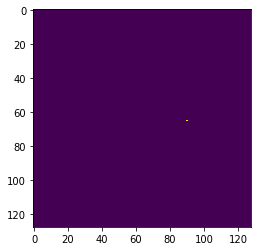

In [334]:
# plt.imshow(segmentation_np[0,44])
plt.imshow((segmentation_np == 4)[0,44])

In [ ]:
post

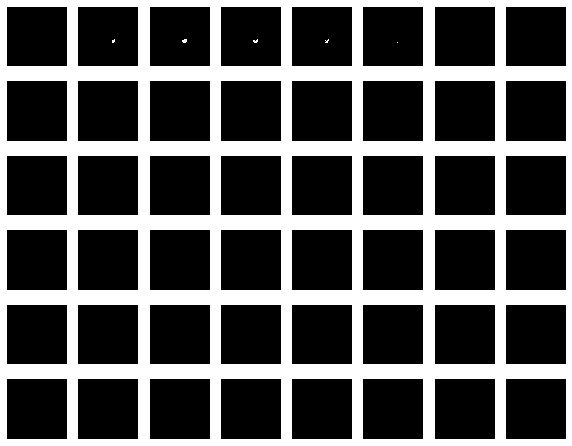

In [111]:
class_idx = 4

fig, axes = plt.subplots(6, 8, figsize=(10,8))
for i in range(48):
    ax = axes.ravel()[i]
    ax.imshow(postprocessed[0, i] == class_idx, cmap='gray', vmin=0, vmax=1)
    ax.axis('off')

In [310]:
segmentation_np.max()

4

In [112]:
from scipy import ndimage

In [134]:
a = np.zeros((5, 5))
a[2, 2] = 1
a

array([[0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.]])

In [154]:
struct2 = ndimage.generate_binary_structure(3, 2)
struct2

array([[[False,  True, False],
        [ True,  True,  True],
        [False,  True, False]],

       [[ True,  True,  True],
        [ True,  True,  True],
        [ True,  True,  True]],

       [[False,  True, False],
        [ True,  True,  True],
        [False,  True, False]]])

In [135]:
ndimage.binary_dilation(a, structure=struct2)

array([[False, False, False, False, False],
       [False,  True,  True,  True, False],
       [False,  True,  True,  True, False],
       [False,  True,  True,  True, False],
       [False, False, False, False, False]])